# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [64]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  
from sklearn.cluster import KMeans
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [177]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [179]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.head(10))
print(feat_info.head(10))

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [66]:
# Identify missing or unknown data values and convert them to NaNs.

##############
# Calculate number of initial NaNs
##############
miss_list = []
cat = []

for i in range(len(feat_info)):
    miss_list.append(feat_info['missing_or_unknown'][i].replace('[','').replace(']',''))
    cat.append(feat_info['attribute'][i])

feat_info_nan = feat_info['missing_or_unknown'].str.split(',')


NaN_initial = azdias.isna().sum().sum()
print('Number of initial NaNs:' , NaN_initial)


##############
# Calculate number of missing and unknown values
##############

cat_num = [] 
for i in range(len(cat)):
    for j in range(len(feat_info_nan[i])):
        try:
            try:
                cat_num.append(len(azdias.groupby(cat[i]).groups[int(feat_info_nan[i][j].replace('[','').replace(']',''))]))
            except:
                cat_num.append(len(azdias.groupby(cat[i]).groups[feat_info_nan[i][j].replace('[','').replace(']','')]))
        except KeyError:
            cat_num.append(0)

total = 0
for el in range(0, len(cat_num)):
    total = total + cat_num[el]

print('Number of missing and unknown values:', total)


##############
# Calculate number of total NaNs values
##############

azdias_n = azdias

for i in range(len(cat)):
    for j in range(len(feat_info_nan[i])):
        try:
            azdias_n.iloc[:,i] = azdias_n.iloc[:,i].replace(int((feat_info_nan[i][j]).replace('[','').replace(']','')),np.nan)  
        except:
            azdias_n.iloc[:,i] = azdias_n.iloc[:,i].replace((feat_info_nan[i][j]).replace('[','').replace(']',''),np.nan)

             
NaN_new = azdias_n.isna().sum().sum()
print('Number of total NaNs:' , NaN_new)

Number of initial NaNs: 4896838
Number of missing and unknown values: 3477091
Number of total NaNs: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

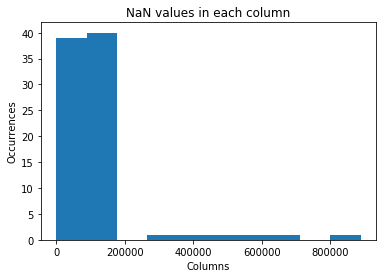

In [67]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
NaN_col = np.array(azdias_n.isna().sum())
plt.hist(NaN_col);
plt.title('NaN values in each column');
plt.xlabel('Columns');
plt.ylabel('Occurrences');

In [68]:
# Investigate patterns in the amount of missing data in each column.
cat_outliers = []
for i in range(len(NaN_col)):
    if NaN_col[i] > 250000:
        print(cat[i], NaN_col[i])
        cat_outliers.append(cat[i])

AGER_TYP 685843
GEBURTSJAHR 392318
TITEL_KZ 889061
ALTER_HH 310267
KK_KUNDENTYP 584612
KBA05_BAUMAX 476524


In [69]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_n1 = azdias_n
azdias_n1.drop(azdias_n1[cat_outliers],axis=1,inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Based on the histogram shown above, there are six features with more than 250.000 missing or unknown data, that is at least 28% of the dataset and can be dismissed: best-ager typology, year of birth, academic title flag, birthdate of head of household, consumer pattern over past 12 months and most common building type within the microcell. The first three features are relating to the single person, the fourth and the fifth to the household and the last one is a RR3 micro-cell feature. The best-ager typology can be replaced by the dominating movement of person's youth feature (PRAEGENDE_JUGENDJAHRE) and the life stage (LP_LEBENSPHASE_FEIN), as well as the year of birth by estimated age based on given name analysis (ALTERSKATEGORIE_GROB) and the academic title flag is almost full of unknown values (99.8%), so it can be disregarded directly. The birthdate of head of household can be estimated by family type (LP_FAMILIE_FEIN), the number of adults (ANZ_PERSONEN) and the likelihood of children (W_KEIT_KIND_HH), the consumer pattern over past 12 months by the estimated household net income (HH_EINKOMMEN_SCORE), the number of adults (ANZ_PERSONEN) and the shopper typology (SHOPPER_TYP). Lastly the most common building type within the microcell is replaced by the first four features of the RR3 micro-cell, from the number of 1 to 10+ families houses (KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4). 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

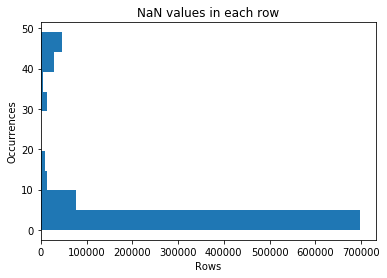

In [70]:
# How much data is missing in each row of the dataset?
NaN_row = azdias_n1.isna().sum(axis = 1)
plt.hist(NaN_row,orientation = 'horizontal');
plt.title('NaN values in each row');
plt.xlabel('Rows');
plt.ylabel('Occurrences');

In [71]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
cat_outliers_r1 = []
cat_outliers_r2 = []
azdias_n_subset1 = azdias_n1.copy()
azdias_n_subset2 = azdias_n1.copy()

for i in range(len(NaN_row)):
    if NaN_row[i] < 10:
        cat_outliers_r1.append(i)
    else:
        cat_outliers_r2.append(i)
        
# Data points below the threshold of 10 NaN in the row 
azdias_n_subset1.drop(azdias_n_subset1.index[cat_outliers_r2],axis=0,inplace=True)

# Data points above the threshold of 10 NaN in the row
azdias_n_subset2.drop(azdias_n_subset2.index[cat_outliers_r1],axis=0,inplace=True)

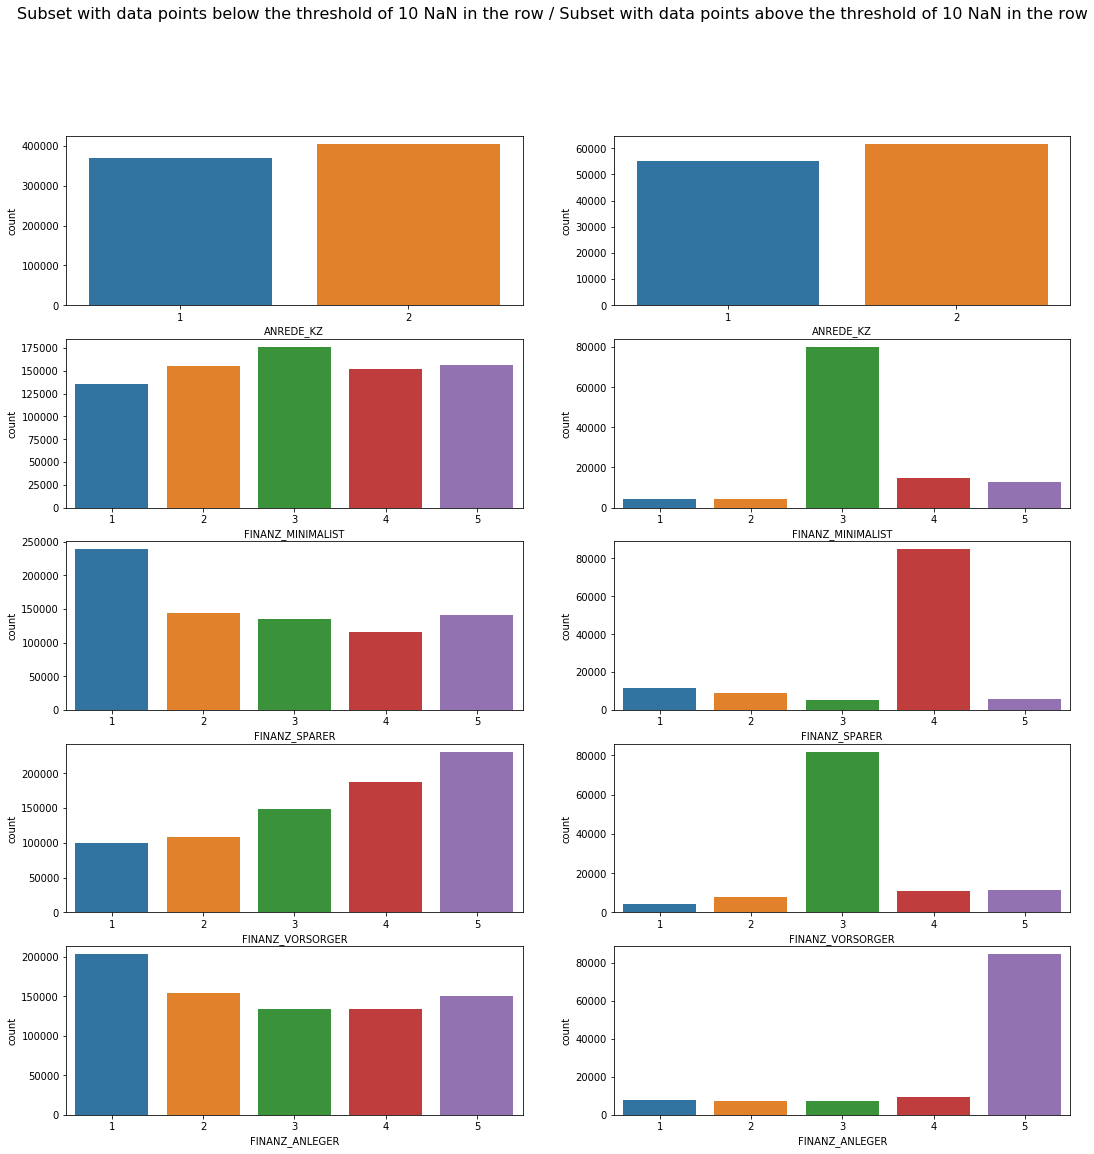

In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

azdias_n_subset1_nan = azdias_n_subset1.isna().sum()
azdias_n_subset2_nan = azdias_n_subset2.isna().sum()
azdias_n_subset_nan_cat = []

for i in range(len(azdias_n_subset1_nan)):
    if azdias_n_subset1_nan[i] == 0 and azdias_n_subset2_nan[i] == 0:
        azdias_n_subset_nan_cat.append(i)

azdias_n_subset_nan_cat_all = azdias_n_subset_nan_cat[:5]

fig, axes = plt.subplots(5, 2, figsize=(18, 18))
fig.suptitle('Subset with data points below the threshold of 10 NaN in the row / \
Subset with data points above the threshold of 10 NaN in the row', fontsize=16)

for i in range(len(azdias_n_subset_nan_cat_all)):
    sns.countplot(ax=axes[i,0], x = azdias_n_subset1.iloc[:,azdias_n_subset_nan_cat_all[i]], data = azdias_n_subset1)
    sns.countplot(ax=axes[i,1], x = azdias_n_subset2.iloc[:,azdias_n_subset_nan_cat_all[i]], data = azdias_n_subset2)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Firstly looking to the histogram it is clear that the threshold to divide the entire dataset is 9.8 NaNs considering the unknown values by rows, so 10 NaNs have been chosen. 
Taking into analysis the graphs above, it is possible to observe a huge difference between the two subsets, where the most frequent feature variable is not always the same, omitting the first one, very similar proportionally. Moreover the graphs of the subset with NaNs below the threshold chosen have a more regular behaviour comparing to the other ones and for this reason the subset above the threshold chosen can be considered as special and will not be considered into the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

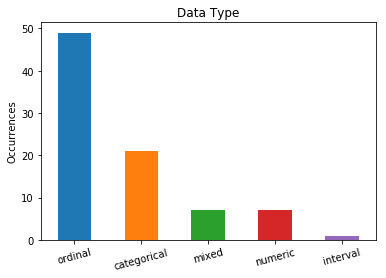

In [72]:
# How many features are there of each data type?
feat_info['type'].value_counts().plot(kind='bar')
plt.xticks(rotation=15);
plt.title('Data Type');
plt.ylabel('Occurrences');

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [73]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

azdias_n_subset1_cat = azdias_n_subset1.copy()

type_cat = feat_info[feat_info['type'] == 'categorical']['attribute'].tolist()

list_binary_cat = []
list_cat = []
list_cat_del = []

for i in range(len(azdias_n_subset1_cat.columns)):
    if azdias_n_subset1_cat.columns[i] in type_cat:
        if azdias_n_subset1_cat.iloc[:,i].nunique() < 3 and \
        isinstance(azdias_n_subset1_cat.iloc[:,i].value_counts().index.values[0],str) == True:
            azdias_n_subset1_cat = pd.concat([azdias_n_subset1_cat,pd.get_dummies(azdias_n_subset1_cat.iloc[:,i],prefix=azdias_n_subset1_cat.columns[i],drop_first=True)],axis=1)
            list_binary_cat.append(azdias_n_subset1_cat.columns[i])
        if  3 <= azdias_n_subset1_cat.iloc[:,i].nunique() < 9:
            azdias_n_subset1_cat = pd.concat([azdias_n_subset1_cat,pd.get_dummies(azdias_n_subset1_cat.iloc[:,i],prefix=azdias_n_subset1_cat.columns[i],drop_first=True)],axis=1)
            list_cat.append(azdias_n_subset1_cat.columns[i])
        if  azdias_n_subset1_cat.iloc[:,i].nunique() > 8:
            list_cat_del.append(azdias_n_subset1_cat.columns[i])
            

for i in range(len(list_binary_cat)):
    azdias_n_subset1_cat = azdias_n_subset1_cat.drop(list_binary_cat[i],axis=1)    
for i in range(len(list_cat)):
    azdias_n_subset1_cat = azdias_n_subset1_cat.drop(list_cat[i],axis=1)    
for i in range(len(list_cat_del)):
    azdias_n_subset1_cat = azdias_n_subset1_cat.drop(list_cat_del[i],axis=1)

print('The number of features with more than 8-level variables are', len(list_cat_del), \
      'and were disregarded from the analysis.')
print('The number of features with less than 8-level variables are', len(list_cat), \
      'and were encoded.')

The number of features with more than 8-level variables are 5 and were disregarded from the analysis.
The number of features with less than 8-level variables are 8 and were encoded.


#### Discussion 1.2.1: Re-Encode Categorical Features

Based on the 21 initial categorical data 3 were removed because characterized by a huge number of unknown elements. Thus after creating a dummy variable for the only binary categorical feature in the dataset, it is arbitrarily considered a limit of 8-level variables for the other ones. The number of features above the threshold chosen are five and they were disregarded from the analysis and the features between three and eight values were encoded with get_dummies function, dropping the first numeric level.   

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [74]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
type_mxd = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
azdias_n_subset1_mxd = azdias_n_subset1_cat.copy()


col_mod = azdias_n_subset1_mxd.columns.get_loc('PRAEGENDE_JUGENDJAHRE')
azdias_n_subset1_mxd.insert(col_mod+1, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',azdias_n_subset1_mxd['PRAEGENDE_JUGENDJAHRE'])
azdias_n_subset1_mxd = azdias_n_subset1_mxd.rename(columns = \
{'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_JUGENDJAHRE_DECADE'}, inplace = False)    
  
# Set of tens represent the decades   
azdias_n_subset1_mxd.iloc[:,col_mod] = azdias_n_subset1_mxd.iloc[:,col_mod].replace(1.0,40)\
.replace(2.0,40).replace(3.0,50).replace(4.0,50).replace(5.0,60).replace(6.0,60).replace(7.0,60)\
.replace(8.0,70).replace(9.0,70).replace(10.0,80).replace(11.0,80).replace(12.0,80).replace(13.0,80)\
.replace(14.0,90).replace(15.0,90)

# 1 is for Mainstream and 0 for Avantgarde
azdias_n_subset1_mxd.iloc[:,col_mod+1] = azdias_n_subset1_mxd.iloc[:,col_mod+1].replace(1.0,1)\
.replace(2.0,0).replace(3.0,1).replace(4.0,0).replace(5.0,1).replace(6.0,0).replace(7.0,0)\
.replace(8.0,1).replace(9.0,0).replace(10.0,1).replace(11.0,0).replace(12.0,1).replace(13.0,0)\
.replace(14.0,1).replace(15.0,0)

In [75]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

col_mod1 = azdias_n_subset1_mxd.columns.get_loc('CAMEO_INTL_2015')
azdias_n_subset1_mxd.insert(col_mod1+1, 'CAMEO_INTL_2015_LIFE', azdias_n_subset1_mxd['CAMEO_INTL_2015'])
azdias_n_subset1_mxd = azdias_n_subset1_mxd.rename(columns = \
{'CAMEO_INTL_2015': 'CAMEO_INTL_2015_WEALTH'}, inplace = False)    

# Wealth tipology from 1 (max) to 5 (min)   
azdias_n_subset1_mxd.iloc[:,col_mod1] = azdias_n_subset1_mxd.iloc[:,col_mod1]\
.replace(dict.fromkeys(['11','12','13','14','15'], 1)).replace(dict.fromkeys(['21','22','23','24','25'], 2))\
.replace(dict.fromkeys(['31','32','33','34','35'], 3)).replace(dict.fromkeys(['41','42','43','44','45'], 4))\
.replace(dict.fromkeys(['51','52','53','54','55'], 5))

# Life stage from 1 (younger) to 5 (older)
azdias_n_subset1_mxd.iloc[:,col_mod1+1] = azdias_n_subset1_mxd.iloc[:,col_mod1+1]\
.replace(dict.fromkeys(['11','21','31','41','51'], 1)).replace(dict.fromkeys(['12','22','32','42','52'], 2))\
.replace(dict.fromkeys(['13','23','33','43','53'], 3)).replace(dict.fromkeys(['14','24','34','44','54'], 4))\
.replace(dict.fromkeys(['15','25','35','45','55'], 5))

######

list_mxd_del = []

for i in range(len(azdias_n_subset1_mxd.columns)):
    if azdias_n_subset1_mxd.columns[i] in type_mxd:
        if  azdias_n_subset1_mxd.iloc[:,i].nunique() > 7:
            list_mxd_del.append(azdias_n_subset1_mxd.columns[i])

for i in range(len(list_mxd_del)):
    azdias_n_subset1_mxd = azdias_n_subset1_mxd.drop(list_mxd_del[i],axis=1)
    
print('The number of features with more than 7-level variables are', len(list_mxd_del), \
      'and were disregarded from the analysis.')

# As PLZ8_BAUMAX can be resumed by the first four PLZ8 macro-cell features, it was disregarded. 
azdias_n_subset1_mxd = azdias_n_subset1_mxd.drop('PLZ8_BAUMAX', 1)

The number of features with more than 7-level variables are 3 and were disregarded from the analysis.


#### Discussion 1.2.2: Engineer Mixed-Type Features

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 features were encoded following the decade and the movement variables for the first one and wealth tipology and life stage for the second one, obtaining four columns in all. KBA05_BAUMAX was disregarded previously, PLZ8_BAUMAX for the same reason, since it can be resumed by the first four PLZ8 macro-cell characteristics and finally taking into account the criterion used for the categorical features, a threshold of 7-level variables has been considered, resulting in the exclusion of the last three mixed-type features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [16]:
# The features re-engineered were checked previously step-by-step.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [76]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Identify missing or unknown data values and convert them to NaNs.

    miss_list = []
    cat = []

    for i in range(len(feat_info)):
        miss_list.append(feat_info['missing_or_unknown'][i].replace('[','').replace(']',''))
        cat.append(feat_info['attribute'][i])

    feat_info_nan = feat_info['missing_or_unknown'].str.split(',')


    ##############
    # Calculate number of missing and unknown values
    ##############

    cat_num = [] 
    for i in range(len(cat)):
        for j in range(len(feat_info_nan[i])):
            try:
                try:
                    cat_num.append(len(df.groupby(cat[i]).groups[int(feat_info_nan[i][j]\
                                                                     .replace('[','').replace(']',''))]))
                except:
                    cat_num.append(len(df.groupby(cat[i]).groups[feat_info_nan[i][j].replace('[','')\
                                                                 .replace(']','')]))
            except KeyError:
                cat_num.append(0)

    total = 0
    for el in range(0, len(cat_num)):
        total = total + cat_num[el]


##############
# Calculate number of total NaNs values
##############


    for i in range(len(cat)):
        for j in range(len(feat_info_nan[i])):
            try:
                df.iloc[:,i] = df.iloc[:,i].replace(int((feat_info_nan[i][j]).\
                                                        replace('[','').replace(']','')),np.nan)  
            except:
                df.iloc[:,i] = df.iloc[:,i].replace((feat_info_nan[i][j]).replace('[','').replace(']',''),np.nan)

             
    NaN_new = df.isna().sum().sum()
   
    
    # ASSESS MISSING FEATURES
    
    # Dropping the columns with highest number of NaNs values 
    
    df = df.drop(['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX'], 1)
    
    # Creating two subsets characterized by the threshold of 10 NaN in the row 
    
    NaN_row = df.isna().sum(axis = 1)
    
    cat_outliers_r1 = []
    cat_outliers_r2 = []
    df1 = df.copy()
    df2 = df.copy()

    for i in range(len(NaN_row)):
        if NaN_row[i] < 10:
            cat_outliers_r1.append(i)
        else:
            cat_outliers_r2.append(i)
        
    # Data points below the threshold of 10 NaN in the row
    df1.drop(df1.index[cat_outliers_r2],axis=0,inplace=True)

    # Data points above the threshold of 10 NaN in the row
    df2.drop(df2.index[cat_outliers_r1],axis=0,inplace=True)

    
    # SELECT AND RE-ENCODE FEATURES
    
    # CATEGORICAL DATA
        
    df1 = pd.concat([df1,pd.get_dummies(df1['CJT_GESAMTTYP'],prefix='CJT_GESAMTTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['FINANZTYP'],prefix='FINANZTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['LP_FAMILIE_GROB'],prefix='LP_FAMILIE_GROB',drop_first=True)],axis=1) 
    df1 = pd.concat([df1,pd.get_dummies(df1['LP_STATUS_GROB'],prefix='LP_STATUS_GROB',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['NATIONALITAET_KZ'],prefix='NATIONALITAET_KZ',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['SHOPPER_TYP'],prefix='SHOPPER_TYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['ZABEOTYP'],prefix='ZABEOTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['GEBAEUDETYP'],prefix='GEBAEUDETYP',drop_first=True)],axis=1)
    df1 = df1.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',\
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP'], 1)

    df1 = df1.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], 1)
    
 
    # MIXED FEATURES
     
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
    type_mxd = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    
    if 'PRAEGENDE_JUGENDJAHRE' in df1.columns:
        col_mod = df1.columns.get_loc('PRAEGENDE_JUGENDJAHRE')
        df1.insert(col_mod+1, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',df1['PRAEGENDE_JUGENDJAHRE'])
        df1 = df1.rename(columns = {'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_JUGENDJAHRE_DECADE'}, inplace = False)    
  
        # Set of tens represent the decades   
        df1.iloc[:,col_mod] = df1.iloc[:,col_mod].replace(1.0,40).replace(2.0,40).replace(3.0,50)\
        .replace(4.0,50).replace(5.0,60).replace(6.0,60).replace(7.0,60).replace(8.0,70).replace(9.0,70)\
        .replace(10.0,80).replace(11.0,80).replace(12.0,80).replace(13.0,80).replace(14.0,90).replace(15.0,90)

        # 1 is for Mainstream and 0 for Avantgarde
        df1.iloc[:,col_mod+1] = df1.iloc[:,col_mod+1].replace(1.0,1).replace(2.0,0).replace(3.0,1)\
        .replace(4.0,0).replace(5.0,1).replace(6.0,0).replace(7.0,0).replace(8.0,1).replace(9.0,0)\
        .replace(10.0,1).replace(11.0,0).replace(12.0,1).replace(13.0,0).replace(14.0,1).replace(15.0,0)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    if 'CAMEO_INTL_2015' in df1.columns:
        col_mod1 = df1.columns.get_loc('CAMEO_INTL_2015')
        df1.insert(col_mod1+1, 'CAMEO_INTL_2015_LIFE', df1['CAMEO_INTL_2015'])
        df1 = df1.rename(columns = {'CAMEO_INTL_2015': 'CAMEO_INTL_2015_WEALTH'}, inplace = False)    

        # Wealth tipology from 1 (max) to 5 (min)   
        df1.iloc[:,col_mod1] = df1.iloc[:,col_mod1].replace(dict.fromkeys(['11','12','13','14','15'], 1))\
        .replace(dict.fromkeys(['21','22','23','24','25'], 2)).replace(dict.fromkeys(['31','32','33','34','35'], 3))\
        .replace(dict.fromkeys(['41','42','43','44','45'], 4)).replace(dict.fromkeys(['51','52','53','54','55'], 5))

        # Life stage from 1 (younger) to 5 (older)
        df1.iloc[:,col_mod1+1] = df1.iloc[:,col_mod1+1].replace(dict.fromkeys(['11','21','31','41','51'], 1))\
        .replace(dict.fromkeys(['12','22','32','42','52'], 2)).replace(dict.fromkeys(['13','23','33','43','53'], 3))\
        .replace(dict.fromkeys(['14','24','34','44','54'], 4)).replace(dict.fromkeys(['15','25','35','45','55'], 5))
        
    ######
    
    df1 = df1.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], 1)

    # As PLZ8_BAUMAX can be resumed by the first four PLZ8 macro-cell features, it is disregarded. 
    df1 = df1.drop('PLZ8_BAUMAX', 1)
    
    # Binary categorical feature with string values.
    df1 = pd.concat([df1,pd.get_dummies(df1['OST_WEST_KZ'],prefix='OST_WEST_KZ',drop_first=True)],axis=1)
    df1 = df1.drop('OST_WEST_KZ', 1) 
    
    # As the integer 7 does not compare on GEBAEUDETYP, a zero column it is added.
    zeros_5 = np.zeros(len(df1))   
    df1.insert(df1.columns.get_loc('GEBAEUDETYP_6.0'), 'GEBAEUDETYP_5.0', zeros_5)

    
    ############
    
    
    # SELECT AND RE-ENCODE FEATURES
    
    # CATEGORICAL DATA
        
    df2 = pd.concat([df2,pd.get_dummies(df2['CJT_GESAMTTYP'],prefix='CJT_GESAMTTYP',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['FINANZTYP'],prefix='FINANZTYP',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['LP_FAMILIE_GROB'],prefix='LP_FAMILIE_GROB',drop_first=True)],axis=1) 
    df2 = pd.concat([df2,pd.get_dummies(df2['LP_STATUS_GROB'],prefix='LP_STATUS_GROB',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['NATIONALITAET_KZ'],prefix='NATIONALITAET_KZ',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['SHOPPER_TYP'],prefix='SHOPPER_TYP',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['ZABEOTYP'],prefix='ZABEOTYP',drop_first=True)],axis=1)
    df2 = pd.concat([df2,pd.get_dummies(df2['GEBAEUDETYP'],prefix='GEBAEUDETYP',drop_first=True)],axis=1)
    df2 = df2.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',\
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP'], 1)

    df2 = df2.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], 1)
    
 
    # MIXED FEATURES
     
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
    type_mxd = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    
    if 'PRAEGENDE_JUGENDJAHRE' in df2.columns:
        col_mod = df2.columns.get_loc('PRAEGENDE_JUGENDJAHRE')
        df2.insert(col_mod+1, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',df2['PRAEGENDE_JUGENDJAHRE'])
        df2 = df2.rename(columns = {'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_JUGENDJAHRE_DECADE'}, inplace = False)    
  
        # Set of tens represent the decades   
        df2.iloc[:,col_mod] = df2.iloc[:,col_mod].replace(1.0,40).replace(2.0,40).replace(3.0,50)\
        .replace(4.0,50).replace(5.0,60).replace(6.0,60).replace(7.0,60).replace(8.0,70).replace(9.0,70)\
        .replace(10.0,80).replace(11.0,80).replace(12.0,80).replace(13.0,80).replace(14.0,90).replace(15.0,90)

        # 1 is for Mainstream and 0 for Avantgarde
        df2.iloc[:,col_mod+1] = df2.iloc[:,col_mod+1].replace(1.0,1).replace(2.0,0).replace(3.0,1)\
        .replace(4.0,0).replace(5.0,1).replace(6.0,0).replace(7.0,0).replace(8.0,1).replace(9.0,0)\
        .replace(10.0,1).replace(11.0,0).replace(12.0,1).replace(13.0,0).replace(14.0,1).replace(15.0,0)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    if 'CAMEO_INTL_2015' in df2.columns:
        col_mod1 = df2.columns.get_loc('CAMEO_INTL_2015')
        df2.insert(col_mod1+1, 'CAMEO_INTL_2015_LIFE', df2['CAMEO_INTL_2015'])
        df2 = df2.rename(columns = {'CAMEO_INTL_2015': 'CAMEO_INTL_2015_WEALTH'}, inplace = False)    

        # Wealth tipology from 1 (max) to 5 (min)   
        df2.iloc[:,col_mod1] = df2.iloc[:,col_mod1].replace(dict.fromkeys(['11','12','13','14','15'], 1))\
        .replace(dict.fromkeys(['21','22','23','24','25'], 2)).replace(dict.fromkeys(['31','32','33','34','35'], 3))\
        .replace(dict.fromkeys(['41','42','43','44','45'], 4)).replace(dict.fromkeys(['51','52','53','54','55'], 5))

        # Life stage from 1 (younger) to 5 (older)
        df2.iloc[:,col_mod1+1] = df2.iloc[:,col_mod1+1].replace(dict.fromkeys(['11','21','31','41','51'], 1))\
        .replace(dict.fromkeys(['12','22','32','42','52'], 2)).replace(dict.fromkeys(['13','23','33','43','53'], 3))\
        .replace(dict.fromkeys(['14','24','34','44','54'], 4)).replace(dict.fromkeys(['15','25','35','45','55'], 5))
        
    ######
    
    df2 = df2.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], 1)

    # As PLZ8_BAUMAX can be resumed by the first four PLZ8 macro-cell features, it is disregarded. 
    df2 = df2.drop('PLZ8_BAUMAX', 1)
    
    # Binary categorical feature with string values.
    df2 = pd.concat([df2,pd.get_dummies(df2['OST_WEST_KZ'],prefix='OST_WEST_KZ',drop_first=True)],axis=1)
    df2 = df2.drop('OST_WEST_KZ', 1) 
    
    # As the integer 7 does not compare on GEBAEUDETYP, a zero column it is added.
    zeros_5 = np.zeros(len(df2))   
    df2.insert(df2.columns.get_loc('GEBAEUDETYP_6.0'), 'GEBAEUDETYP_5.0', zeros_5)
    
    

    return df1, df2
    

In [77]:
def clean_data_general_many_nan(df1):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # SELECT AND RE-ENCODE FEATURES
    
    # CATEGORICAL DATA
        
    df1 = pd.concat([df1,pd.get_dummies(df1['CJT_GESAMTTYP'],prefix='CJT_GESAMTTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['FINANZTYP'],prefix='FINANZTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['LP_FAMILIE_GROB'],prefix='LP_FAMILIE_GROB',drop_first=True)],axis=1) 
    df1 = pd.concat([df1,pd.get_dummies(df1['LP_STATUS_GROB'],prefix='LP_STATUS_GROB',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['NATIONALITAET_KZ'],prefix='NATIONALITAET_KZ',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['SHOPPER_TYP'],prefix='SHOPPER_TYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['ZABEOTYP'],prefix='ZABEOTYP',drop_first=True)],axis=1)
    df1 = pd.concat([df1,pd.get_dummies(df1['GEBAEUDETYP'],prefix='GEBAEUDETYP',drop_first=True)],axis=1)
    df1 = df1.drop(['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP'], 1)

    df1 = df1.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], 1)
    
 
    # MIXED FEATURES
     
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    
    type_mxd = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    
    if 'PRAEGENDE_JUGENDJAHRE' in df1.columns:
        col_mod = df1.columns.get_loc('PRAEGENDE_JUGENDJAHRE')
        df1.insert(col_mod+1, 'PRAEGENDE_JUGENDJAHRE_MOVEMENT',df1['PRAEGENDE_JUGENDJAHRE'])
        df1 = df1.rename(columns = {'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_JUGENDJAHRE_DECADE'}, inplace = False)    
  
        # Set of tens represent the decades   
        df1.iloc[:,col_mod] = df1.iloc[:,col_mod].replace(1.0,40).replace(2.0,40).replace(3.0,50)\
        .replace(4.0,50).replace(5.0,60).replace(6.0,60).replace(7.0,60).replace(8.0,70).replace(9.0,70)\
        .replace(10.0,80).replace(11.0,80).replace(12.0,80).replace(13.0,80).replace(14.0,90).replace(15.0,90)

        # 1 is for Mainstream and 0 for Avantgarde
        df1.iloc[:,col_mod+1] = df1.iloc[:,col_mod+1].replace(1.0,1).replace(2.0,0).replace(3.0,1)\
        .replace(4.0,0).replace(5.0,1).replace(6.0,0).replace(7.0,0).replace(8.0,1).replace(9.0,0)\
        .replace(10.0,1).replace(11.0,0).replace(12.0,1).replace(13.0,0).replace(14.0,1).replace(15.0,0)
    
    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    if 'CAMEO_INTL_2015' in df1.columns:
        col_mod1 = df1.columns.get_loc('CAMEO_INTL_2015')
        df1.insert(col_mod1+1, 'CAMEO_INTL_2015_LIFE', df1['CAMEO_INTL_2015'])
        df1 = df1.rename(columns = {'CAMEO_INTL_2015': 'CAMEO_INTL_2015_WEALTH'}, inplace = False)    

        # Wealth tipology from 1 (max) to 5 (min)   
        df1.iloc[:,col_mod1] = df1.iloc[:,col_mod1].replace(dict.fromkeys(['11','12','13','14','15'], 1))\
        .replace(dict.fromkeys(['21','22','23','24','25'], 2)).replace(dict.fromkeys(['31','32','33','34','35'], 3))\
        .replace(dict.fromkeys(['41','42','43','44','45'], 4)).replace(dict.fromkeys(['51','52','53','54','55'], 5))

        # Life stage from 1 (younger) to 5 (older)
        df1.iloc[:,col_mod1+1] = df1.iloc[:,col_mod1+1].replace(dict.fromkeys(['11','21','31','41','51'], 1))\
        .replace(dict.fromkeys(['12','22','32','42','52'], 2)).replace(dict.fromkeys(['13','23','33','43','53'], 3))\
        .replace(dict.fromkeys(['14','24','34','44','54'], 4)).replace(dict.fromkeys(['15','25','35','45','55'], 5))
        
    ######
    
    df1 = df1.drop(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE'], 1)

    # As PLZ8_BAUMAX can be resumed by the first four PLZ8 macro-cell features, it is disregarded. 
    df1 = df1.drop('PLZ8_BAUMAX', 1)
    
    # Binary categorical feature with string values.
    df1 = pd.concat([df1,pd.get_dummies(df1['OST_WEST_KZ'],prefix='OST_WEST_KZ',drop_first=True)],axis=1)
    df1 = df1.drop('OST_WEST_KZ', 1) 
    
    # As the integer 7 does not compare on GEBAEUDETYP, a zero column it is added.
    zeros_5 = np.zeros(len(df1))   
    df1.insert(df1.columns.get_loc('GEBAEUDETYP_6.0'), 'GEBAEUDETYP_5.0', zeros_5)


    return df1
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [78]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_red = azdias_n_subset1_mxd
nan_100 = azdias_red.isna().sum().sum() / azdias_red.size * 100
print('The percentage of NaN values in the original dataset is:', nan_100,'%')
nan_col_100 = azdias_red.isna().sum().max() / len(azdias_red) * 100
print('The percentage of the maximum NaN value in a column is:', nan_col_100,'%')

imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer_data = imputer.fit_transform(azdias_red)

azdias_red = pd.DataFrame(data = imputer_data, index=azdias_red.index, columns=azdias_red.columns)

if azdias_red.isna().sum().sum() == 0:
    print('New dataset is cleaned of all NaN values, replaced by the mean.')
else:
    print('Dataset is not cleaned of all NaN values.')

The percentage of NaN values in the original dataset is: 0.672294040786 %
The percentage of the maximum NaN value in a column is: 7.1323006468 %
New dataset is cleaned of all NaN values, replaced by the mean.


In [79]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaler_data = scaler.fit_transform(azdias_red)

azdias_scal = pd.DataFrame(data = scaler_data, index=azdias_red.index, columns=azdias_red.columns)

print(azdias_scal.head())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1             -1.765007   0.958422          -1.488785       1.540017   
2              0.199492   0.958422          -1.488785       0.867244   
3              1.181742   0.958422           0.689233      -0.478302   
4              0.199492  -1.043381           0.689233       0.194471   
5             -1.765007   0.958422          -0.036773      -1.151076   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1         -1.044684        1.468541               0.981043          1.327209   
2         -1.770775       -0.568811               0.263375          1.327209   
3          1.133590       -0.568811              -1.171961         -0.818216   
4          0.407498       -1.247929               0.263375         -0.818216   
5          1.133590       -0.568811              -0.454293          1.327209   

   GREEN_AVANTGARDE  HEALTH_TYP      ...        ZABEOTYP_4  ZABEOTYP_5  \
1         -0

### Discussion 2.1: Apply Feature Scaling

The percentage of NaN values in the entire original dataset is 0.67%, a tiny value, and the maximum in a single column is 7.13%, admissible for this research, which allows to replace them by the mean of each columns using an Imputer. Then a feature scaling was applied using the StandardScaler, with each feature with a mean of 0 and a standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [21]:
# Apply PCA to the data.
pca = PCA(n_components = int(len(azdias_scal.columns)/2))
principalComponents = pca.fit_transform(azdias_scal)
print(pca.explained_variance_ratio_)

[ 0.12120019  0.10137889  0.0651055   0.04137068  0.02773064  0.02283177
  0.0220113   0.02027697  0.01862192  0.01765292  0.01725995  0.01667629
  0.01571235  0.01450103  0.01375399  0.013548    0.01314502  0.01297821
  0.01249946  0.01232794  0.01213483  0.01164344  0.01139766  0.01101105
  0.01091772  0.01079392  0.01061764  0.01051223  0.01033964  0.01023988
  0.01021508  0.01020504  0.01001924  0.0099375   0.00973758  0.00962887
  0.00935196  0.00899472  0.00874356  0.008613    0.00849534  0.00827953
  0.00795754  0.0077612   0.00754962  0.00726823  0.00702354  0.00682488
  0.00658392]


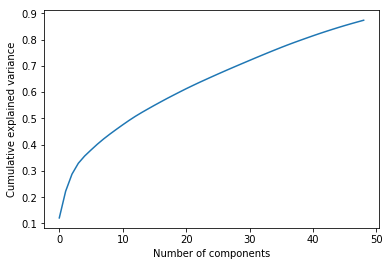

In [16]:
# Investigate the variance accounted for by each principal component.
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance');

In [80]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 40)
principalComponents = pca.fit_transform(azdias_scal)
feature_weights = pca.components_ 
print((pca.explained_variance_ratio_).sum())

0.804928809032


### Discussion 2.2: Perform Dimensionality Reduction

Starting from the half number of features of the dataset (49 - ed) it is possible to observe from the graph that the cumulative explained variance is close to 90%, so reducing the number of components to 40, the variance retained is 80.5%, representing most of the essential characteristics of the data.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

Index(['KBA05_ANTG1', 'MOBI_REGIO', 'FINANZ_MINIMALIST'], dtype='object')
KBA05_ANTG1         -0.201466
MOBI_REGIO          -0.214977
FINANZ_MINIMALIST   -0.221971
Name: 0, dtype: float64
Index(['PLZ8_ANTG3', 'PLZ8_ANTG4', 'HH_EINKOMMEN_SCORE'], dtype='object')
PLZ8_ANTG3            0.196486
PLZ8_ANTG4            0.190612
HH_EINKOMMEN_SCORE    0.188800
Name: 0, dtype: float64


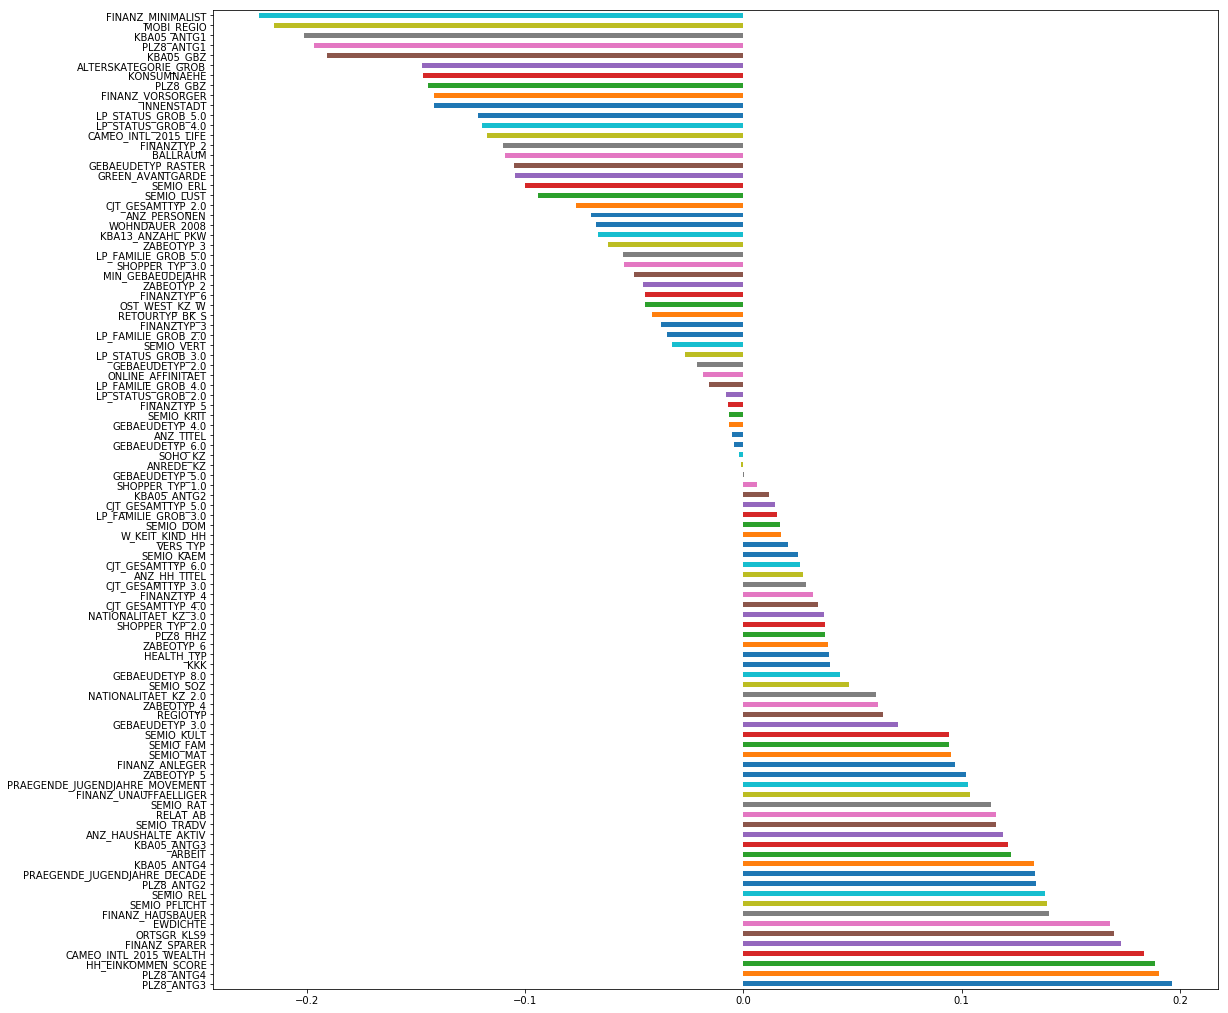

In [61]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(feature_weights, pc):

    arr_sel = pd.DataFrame(feature_weights, columns=azdias_scal.columns).iloc[pc-1,:].sort_values(ascending = False)
    arr_sel.plot(kind = 'barh',figsize=(18, 18));    
    print(arr_sel.index[-3:])
    print(arr_sel[-3:])
    print(arr_sel.index[:3])
    print(arr_sel[:3])

# First principal component is specified with 1.
map_weights(feature_weights, 1)    

Index(['FINANZ_UNAUFFAELLIGER', 'SEMIO_REL', 'PRAEGENDE_JUGENDJAHRE_DECADE'], dtype='object')
FINANZ_UNAUFFAELLIGER          -0.202866
SEMIO_REL                      -0.205252
PRAEGENDE_JUGENDJAHRE_DECADE   -0.221223
Name: 1, dtype: float64
Index(['ALTERSKATEGORIE_GROB', 'ZABEOTYP_3', 'FINANZ_VORSORGER'], dtype='object')
ALTERSKATEGORIE_GROB    0.215650
ZABEOTYP_3              0.203167
FINANZ_VORSORGER        0.202298
Name: 1, dtype: float64


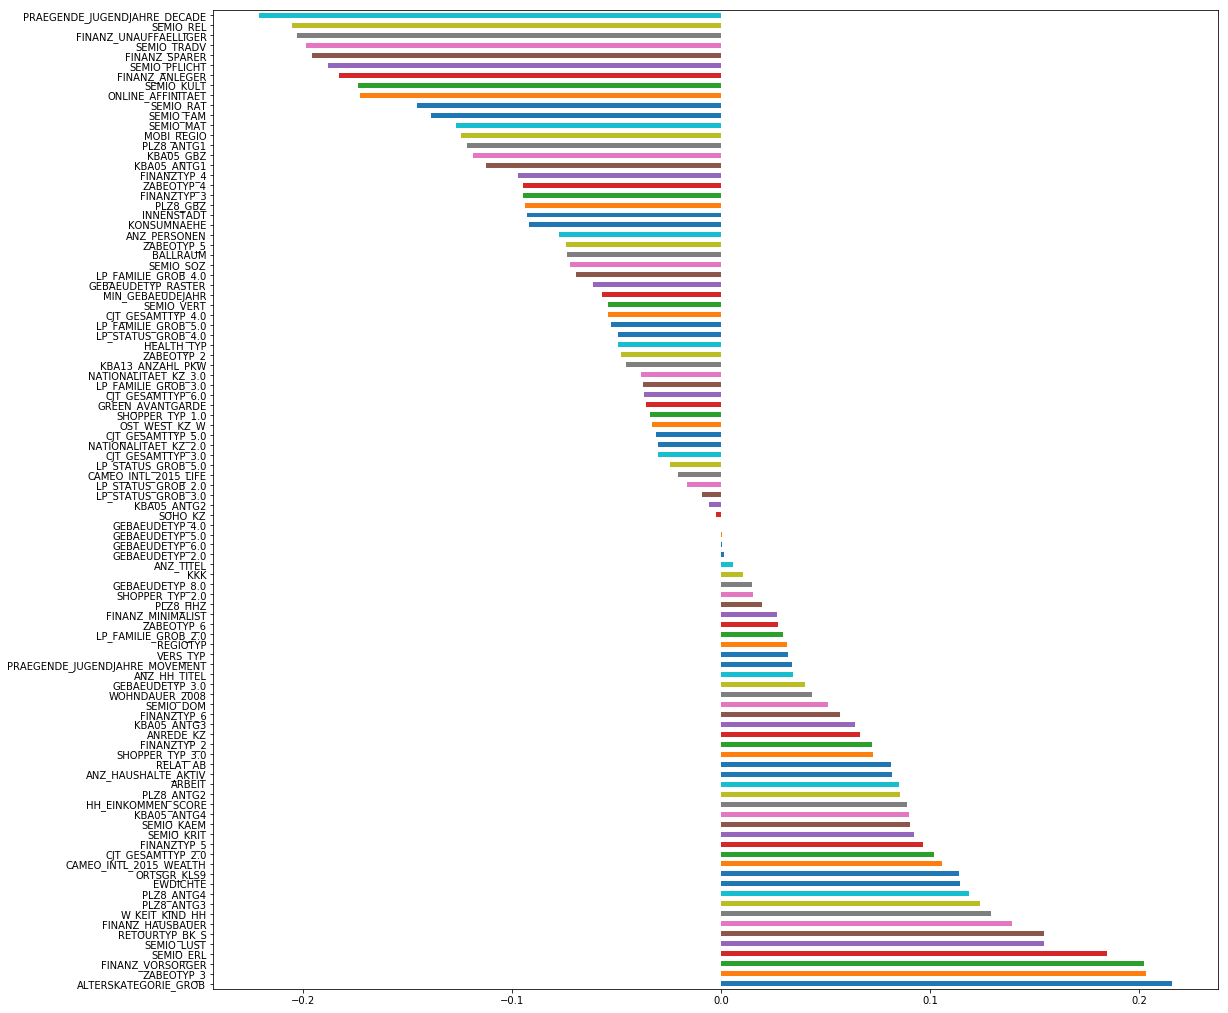

In [24]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Second principal component is specified with 2.
map_weights(feature_weights, 2) 

Index(['SEMIO_DOM', 'SEMIO_KAEM', 'ANREDE_KZ'], dtype='object')
SEMIO_DOM    -0.304258
SEMIO_KAEM   -0.332885
ANREDE_KZ    -0.362045
Name: 2, dtype: float64
Index(['SEMIO_VERT', 'SEMIO_SOZ', 'SEMIO_FAM'], dtype='object')
SEMIO_VERT    0.337547
SEMIO_SOZ     0.262311
SEMIO_FAM     0.258739
Name: 2, dtype: float64


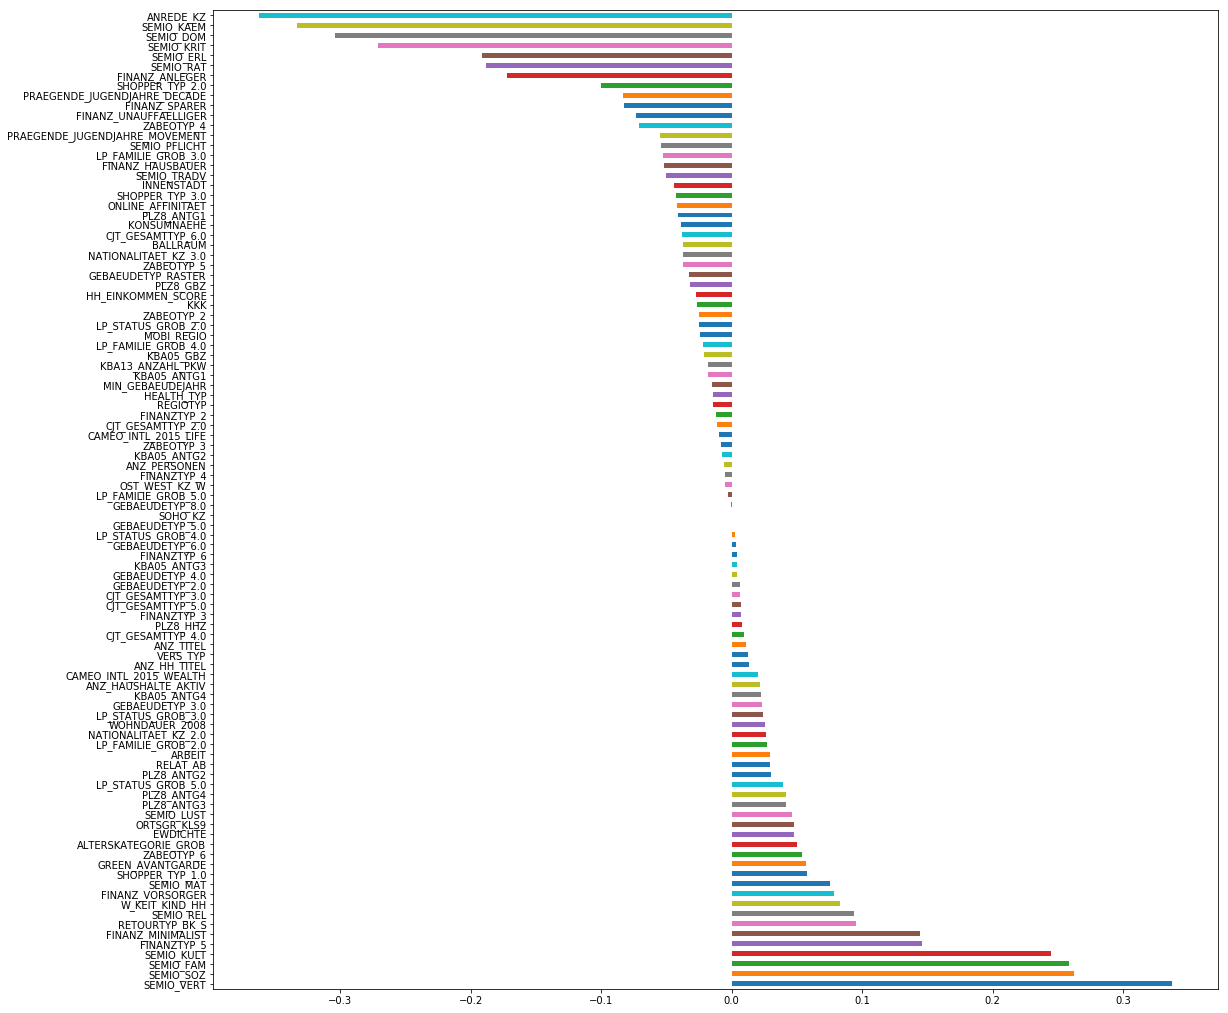

In [25]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# Third principal component is specified with 3.
map_weights(feature_weights, 3) 

### Discussion 2.3: Interpret Principal Components

The analysis of the three first principal components, mapping the six most interesting weights (three positive and three negative) is performed. A difference of the signs indicates a negative correlation: if one feature is positive and the other one is negative, increasing the first one leads to a decrease of the second one. Thus for the first principal component the highest values of the weights are the number of 6-10 family houses in the PLZ8 region (PLZ8_ANTG3), the number of 10+ family houses in the PLZ8 region (PLZ8_ANTG4) and the estimated household net income (HH_EINKOMMEN_SCORE), in contrast to the number of 1-2 family houses in the microcell (KBA05_ANTG1), movement patterns (MOBI_REGIO) and the low financial interest (FINANZ_MINIMALIST). An increase of the high number of families houses of macro-cells and a household net income can reduce the low number of families in the micro-cells, as well as the movement patterns (the family components tend to not relocate) and the low investor typology, as investing is not a priority. For the second principal component the highest values are the estimated age based on given name analysis (ALTERSKATEGORIE_GROB), the fair supplied energy consumption (ZABEOTYP_3) and a profile of investor to be prepared (FINANZ_VORSORGER) and the lowest are a inconspicuous investor (FINANZ_UNAUFFAELLIGER), a religious individual typology (SEMIO_REL) and the dominating movement of person's youth (PRAEGENDE_JUGENDJAHRE_DECADE). In this case it concerns more with person-level features, where on one side there is progressive investor who takes care of energy consuptions and on the other one there is a conservative religious human being. Finally the third principal component is characterized by dreamful (SEMIO_VERT), socially-minded (SEMIO_SOZ) and family-minded (SEMIO_FAM) personalities in contradistinction to a dominant-minded (SEMIO_DOM), combative attitude (SEMIO_KAEM) and the gender (ANREDE_KZ). So it represents a total opposition of personalities, one more quiete and social against one more hostile and argumentative.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

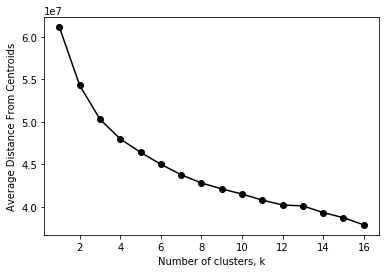

In [18]:
# Over a number of different cluster counts run k-means clustering on the data and 
# compute the average within-cluster distances.     

scores = [] 
centers = range(1,17)
  
for center in centers:
    kmeans = KMeans(n_clusters=center)
    model = kmeans.fit(principalComponents)
    scores.append(abs(model.score(principalComponents)))

plt.plot(list(centers), scores, '-o', color='black')
plt.xlabel('Number of clusters, k')
plt.ylabel('Average Distance From Centroids')
plt.show()

In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

n_clusters_set = 13
kmeans = KMeans(n_clusters=n_clusters_set)
model = kmeans.fit(principalComponents)
general_prediction = kmeans.predict(principalComponents)

In [82]:
# Cluster predictions for general data with many NaN values

general_data_many = clean_data_general_many_nan(azdias_n_subset2)

nan_100 = general_data_many.isna().sum().sum() / general_data_many.size * 100
print('The percentage of NaN values in the general dataset with many missing values is:', nan_100,'%')

# Imputer application
imputer_data = imputer.transform(general_data_many)
general_data_many = pd.DataFrame(data = imputer_data, \
                                  index=general_data_many.index, columns=general_data_many.columns)
if general_data_many.isna().sum().sum() == 0:
    print('New dataset is cleaned of all NaN values, replaced by the mean.')
else:
    print('Dataset is not cleaned of all NaN values.')

# Feature scaling application
general_data_many = scaler.transform(general_data_many)

# PCA application
general_data_many_pca = pca.transform(general_data_many)

# k-means application
general_many_prediction = kmeans.predict(general_data_many_pca)

The percentage of NaN values in the general dataset with many missing values is: 31.1086511563 %
New dataset is cleaned of all NaN values, replaced by the mean.


### Discussion 3.1: Apply Clustering to General Population

Based on different clusters runs (in total 16) performed on PCA - transformed data, the average within-cluster distances represented by score method show that the more significant elbow is around thirteen clusters, so a re-fit of k-means is applied. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [84]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_data_few, customers_data_many = clean_data(customers)

nan_100 = customers_data_few.isna().sum().sum() / customers_data_few.size * 100
print('The percentage of NaN values in the customer dataset with few missing values is:', nan_100,'%')
nan_col_100 = customers_data_few.isna().sum().max() / len(customers_data_few) * 100
print('The percentage of the maximum NaN value in a column is:', nan_col_100,'%')

# Imputer application
imputer_data = imputer.transform(customers_data_few)
customers_data_few = pd.DataFrame(data = imputer_data, \
                                  index=customers_data_few.index, columns=customers_data_few.columns)
if customers_data_few.isna().sum().sum() == 0:
    print('New dataset is cleaned of all NaN values, replaced by the mean.')
else:
    print('Dataset is not cleaned of all NaN values.')

# Feature scaling application
customers_data_few = scaler.transform(customers_data_few)

# PCA application
customers_data_few_pca = pca.transform(customers_data_few)

# k-means application
customers_few_prediction = kmeans.predict(customers_data_few_pca)


######


nan_100 = customers_data_many.isna().sum().sum() / customers_data_many.size * 100
print('The percentage of NaN values in the customer dataset with many missing values is:', nan_100,'%')

# Imputer application
imputer_data = imputer.transform(customers_data_many)
customers_data_many = pd.DataFrame(data = imputer_data, \
                                  index=customers_data_many.index, columns=customers_data_many.columns)
if customers_data_many.isna().sum().sum() == 0:
    print('New dataset is cleaned of all NaN values, replaced by the mean.')
else:
    print('Dataset is not cleaned of all NaN values.')

# Feature scaling application
customers_data_many = scaler.transform(customers_data_many)

# PCA application
customers_data_many_pca = pca.transform(customers_data_many)

# k-means application
customers_many_prediction = kmeans.predict(customers_data_many_pca)


The percentage of NaN values in the customer dataset with few missing values is: 0.488894211464 %
The percentage of the maximum NaN value in a column is: 6.35433573983 %
New dataset is cleaned of all NaN values, replaced by the mean.
The percentage of NaN values in the customer dataset with many missing values is: 34.2017581184 %
New dataset is cleaned of all NaN values, replaced by the mean.


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

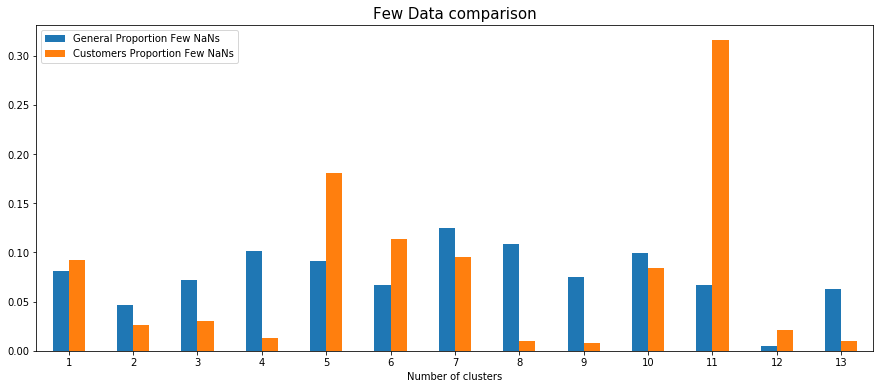

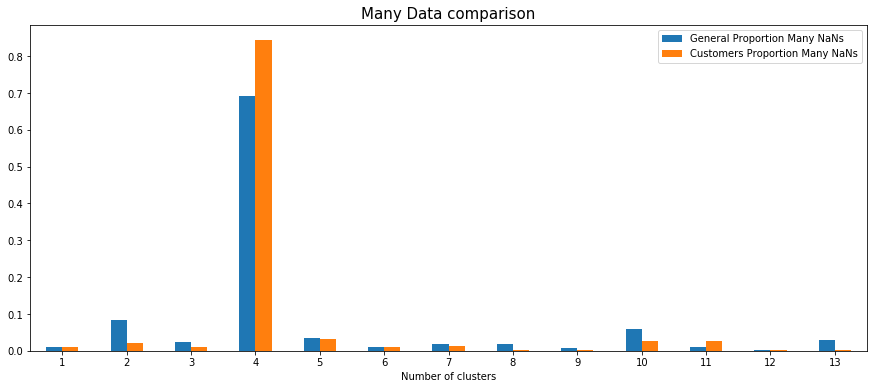

In [152]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

gen_prop_few_nan = []
gen_prop_many_nan = []
cons_prop_few_nan = []
cons_prop_many_nan = []
clus = list(range(1,14))

for i in range(n_clusters_set):
    gen_prop_few_nan.append((general_prediction == i).sum() / len(general_prediction))
    cons_prop_few_nan.append((customers_few_prediction == i).sum() / len(customers_few_prediction))
    gen_prop_many_nan.append((general_many_prediction == i).sum() / len(general_many_prediction))
    cons_prop_many_nan.append((customers_many_prediction == i).sum() / len(customers_many_prediction))

df = pd.DataFrame({'Number of clusters' : clus,\
                   'General Proportion Few NaNs': gen_prop_few_nan,\
                   'Customers Proportion Few NaNs': cons_prop_few_nan})

df.plot(x = 'Number of clusters', y = ['General Proportion Few NaNs', 'Customers Proportion Few NaNs'],\
        kind="bar", figsize=(15, 6));

plt.xticks(rotation=360)
plt.title('Few Data comparison', fontsize=15)
plt.show()



###### 

df1 = pd.DataFrame({'Number of clusters' : clus,\
                   'General Proportion Many NaNs': gen_prop_many_nan,\
                   'Customers Proportion Many NaNs': cons_prop_many_nan})

df1.plot(x = 'Number of clusters', y = ['General Proportion Many NaNs', 'Customers Proportion Many NaNs'],\
        kind="bar", figsize=(15, 6));

plt.xticks(rotation=360)
plt.title('Many Data comparison', fontsize=15)
plt.show()

The cluster which best represents the customer data is the number: 11 .

2     2.974435
3     2.630263
11    0.669845
23    0.259587
15    0.237853
28    0.220287
33    0.197326
13    0.194220
20    0.158027
21    0.145648
dtype: float64


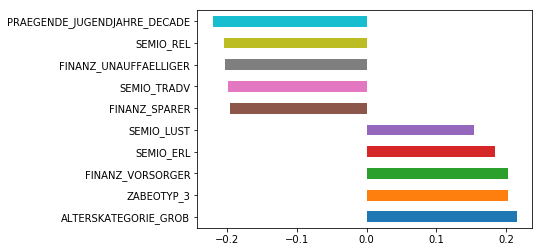

In [163]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

cluster_max = np.argmax(cons_prop_few_nan)

print('The cluster which best represents the customer data is the number:', cluster_max + 1,'.')
print('')

data_over = pd.Series(kmeans.cluster_centers_[cluster_max])
print(data_over.sort_values(ascending = False).head(10))

# The first principal component is analyzed

data_over_df = pd.DataFrame(pca.components_, columns=azdias_n_subset1_mxd.columns).iloc[data_over.idxmax()-1]
data_over_df.sort_values(ascending=False, inplace=True)
data_over_df = pd.concat([data_over_df.head(5), data_over_df.tail(5)])
    
data_over_df.plot(kind='barh')
plt.show()

In [172]:
data_over_inv = pd.DataFrame(data = scaler.inverse_transform\
                             (pca.inverse_transform(customers_data_few_pca\
                                                    [np.where(customers_few_prediction==cluster_max)])).round(),\
                              columns=azdias_n_subset1_mxd.columns)
print(data_over_inv.head())
print(data_over_inv['ALTERSKATEGORIE_GROB'].value_counts())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0        1.0                5.0            1.0   
1                   3.0        1.0                5.0            1.0   
2                   3.0        1.0                5.0            0.0   
3                   4.0        1.0                5.0            1.0   
4                   3.0        1.0                5.0            2.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               5.0             1.0                    2.0               3.0   
1               5.0             1.0                    2.0               3.0   
2               5.0             1.0                    2.0               3.0   
3               5.0             0.0                    2.0               2.0   
4               4.0             1.0                    3.0               1.0   

   GREEN_AVANTGARDE  HEALTH_TYP      ...        ZABEOTYP_4  ZABEOTYP_5  \
0           

The cluster which worst represents the customer data is the number: 9 .

0     5.065245
2     2.599579
8     0.575341
7     0.561776
12    0.311141
21    0.260169
14    0.227398
23    0.197957
4     0.183529
27    0.157121
dtype: float64


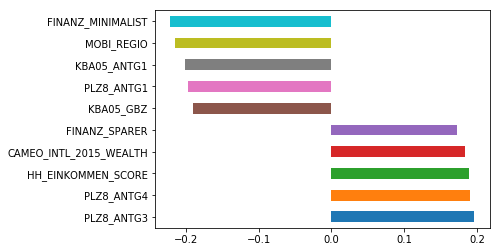

In [165]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

cluster_min = np.argmin(cons_prop_few_nan)

print('The cluster which worst represents the customer data is the number:', cluster_min + 1,'.')
print('')

data_under = pd.Series(kmeans.cluster_centers_[cluster_min])
print(data_under.sort_values(ascending = False).head(10))

# The first principal component is analyzed

data_under_df = pd.DataFrame(pca.components_, columns=azdias_n_subset1_mxd.columns).iloc[data_under.idxmin()-1]
data_under_df.sort_values(ascending=False, inplace=True)
data_under_df = pd.concat([data_under_df.head(5), data_under_df.tail(5)])
    
data_under_df.plot(kind='barh')
plt.show()

In [176]:
data_under_inv = pd.DataFrame(data = scaler.inverse_transform\
                             (pca.inverse_transform(customers_data_few_pca\
                                                    [np.where(customers_few_prediction==cluster_min)])).round(),\
                              columns=azdias_n_subset1_mxd.columns)
print(data_under_inv.head())
print(data_under_inv['HH_EINKOMMEN_SCORE'].value_counts())
print(data_under_inv['CAMEO_INTL_2015_WEALTH'].value_counts())

   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   2.0        1.0                2.0            4.0   
1                   2.0        1.0                3.0            3.0   
2                   2.0        1.0                2.0            4.0   
3                   3.0        1.0                2.0            4.0   
4                   3.0        1.0                2.0            4.0   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0               2.0             3.0                    4.0               4.0   
1               4.0             2.0                    3.0               4.0   
2               2.0             4.0                    3.0               4.0   
3               2.0             3.0                    4.0               4.0   
4               2.0             3.0                    4.0               4.0   

   GREEN_AVANTGARDE  HEALTH_TYP      ...        ZABEOTYP_4  ZABEOTYP_5  \
0           

### Discussion 3.3: Compare Customer Data to Demographics Data

Analyzing the cluster which best represents the customers data over the demographics data, the number 11, it is possible to determine the five features more representive for a customer of a mail-order company. The estimated age based on given name (ALTERSKATEGORIE_GROB), the fair supplied energy consumption typology (ZABEOTYP), a prepared financial profile (FINANZ_VORSORGER), a event-oriented (SEMIO_ERL) and a sensual-minded (SEMIO_LUST) person are its main characteristics. Focusing on the first feature, a count of the single variables is performed and the result shows that the profile is more than sixty years old. 
The most underrepresented cluster is number 9, containing the following consumer attributes: he lives in more than 6 family houses in the PLZ8 region (PLZ8_ANTG3 & PLZ8_ANTG4) in a less affluent household (CAMEO_INTL_2015), has a low estimated household net income (HH_EINKOMMEN_SCORE) and is a money saver (FINANZ_SPARER).  
In conclusion, the typical customer identified by this dataset clustering is a open-minded retired subject, who lives in a region not so dense (lower than 6 family houses) and with a household net income above the average. Moreover the company shoud focus on younger humble profiles, living in high density areas and not inclined to spend a lot.   

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.